In [12]:
import nibabel as nib
import nibabel.processing as nibproc
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from scipy.ndimage import zoom
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import torchsummary

In [2]:
def preprocess_image(image, mask):
    clipped_values = np.percentile(image[mask > 0], 99)
    image_clipped = np.clip(image, a_min=None, a_max=clipped_values)
    image_normalized = (image_clipped - np.min(image_clipped)) / (np.max(image_clipped) - np.min(image_clipped)) * 2 - 1
    return image_normalized

def preprocess_ct_image(image):
    # Clip intensity between -1024 and 3000
    image_clipped = np.clip(image, -1024, 3000)
    
    # Rescale to a range between -1 and 1
    image_scaled = (image_clipped + 1024) / (3000 + 1024) * 2 - 1
    
    return image_scaled

In [ ]:
dir_path = os.getcwd() + "/Task1/train/"
list_files = sorted(os.listdir(dir_path))
# print(list_files)

train = []
for file in list_files:
    mri, ct, mask = read_data(dir_path, file)
    mri = preprocess_mr_image(mri, mask)
    ct = preprocess_mr_image(ct, mask)

    for i in range(50, mri.shape[2]-20, 3):
        mri_slice = mri[:, :, i:i+3]
        ct_slice = ct[:, :, i:i+3]
        mri_slice = resize_image(mri_slice)
        ct_slice = resize_image(ct_slice)
        mri_slice = mri_slice.transpose(2, 0, 1)
        ct_slice = ct_slice.transpose(2, 0, 1)

        train.append((mri_slice, ct_slice))
        print(str(mri_slice.shape) + " || " + str(ct_slice.shape))

#     print("src max: {} | min: {} || target max: {} | min: {}".format(np.max(mri), np.min(mri), np.max(ct), np.min(ct)))

In [ ]:
for mri, ct in train:
    plt.imshow(mri[:,:,1], cmap='gray')
    plt.colorbar()
    plt.title("MRI Scan")
    plt.show()

In [ ]:
for item in train:
    print("source shape : ", item['src'].shape)
    print("target shape : ", item['target'].shape)
    print("\n")
    plt.imshow(item['src'][128:129, :, :], cmap='gray')  # Display the middle slice of the 3D volume
    # plt.imshow(img_data[:, :, img_data.shape[2] // 2], cmap='gray')  # Display the middle slice of the 3D volume
    plt.colorbar()
    plt.title("MRI Scan")
    plt.show()

In [ ]:
dir_path = os.getcwd() + "/evaluation/output_image_test.png"
img = Image.open(dir_path)
img = np.array(img)
print(img.shape)

In [ ]:
plt.imshow(img[:, :, 0], cmap='gray')  # Display the middle slice of the 3D volume
# plt.imshow(img_data[:, :, img_data.shape[2] // 2], cmap='gray')  # Display the middle slice of the 3D volume
plt.colorbar()
plt.title("Generated CT")
plt.show()

In [3]:
def preprocess(img):
    size = 160
    
    if img.shape[0] > size:
        img = img[0:size, :, :]

    if img.shape[1] > size:
        img = img[:, 0:size, :]    
    
    img_padded = np.full((size, size, img.shape[2]), np.min(img))
    x_offset = (abs(size - img.shape[1])) // 2
    y_offset = (abs(size - img.shape[0])) // 2
    img_padded[y_offset:y_offset + img.shape[0], x_offset:x_offset + img.shape[1], :] = img
    img = img_padded
    return img

def read_data (folder, pId):
    input_image_path = "{}/{}/mr.nii.gz".format(folder, pId)
    target_image_path = "{}/{}/ct.nii.gz".format(folder, pId)
    mask_image_path = "{}/{}/mask.nii.gz".format(folder, pId)
    
    x = np.array(nib.load(input_image_path).get_fdata())
    y = np.array(nib.load(target_image_path).get_fdata())
    mask = np.array(nib.load(mask_image_path).get_fdata())
    return (x, y, mask)

def min_max_normalize(img, new_min=0, new_max=1):
    min_val = np.min(img)
    max_val = np.max(img)
    img = (img - min_val) / (max_val - min_val)
    img = img * (new_max - new_min) + new_min
    return img

def apply_mask(img_data, mask_data):
    masked_img = np.zeros_like(img_data)
    masked_img[mask_data > 0] = img_data[mask_data > 0]
    return masked_img

# def resize_image(image, target_size = (256, 256)):
#     zoom_factors = (target_size[0] / image.shape[0], target_size[1] / image.shape[1], 1)
#     resized_image = zoom(image, zoom_factors, order=3, mode='nearest')
#     return resized_image

In [4]:
def resize_image(img, target_size=(160, 160)):
    height, width = img.shape[:2]
    delta_width = width - target_size[1]
    delta_height = height - target_size[0]

    pad_width = max(0, delta_width) // 2
    pad_height = max(0, delta_height) // 2

    crop_box = (
        pad_height,
        pad_height + min(height, target_size[0]),
        pad_width,
        pad_width + min(width, target_size[1])
    )

    img = img[crop_box[0]:crop_box[1], crop_box[2]:crop_box[3]] if delta_width > 0 or delta_height > 0 else img

    if delta_width < 0 or delta_height < 0:
        pad_color = np.min(img)  
        new_img = np.full((target_size[0], target_size[1]), pad_color, dtype=img.dtype)
        new_img[
            (target_size[0] - img.shape[0]) // 2:(target_size[0] + img.shape[0]) // 2,
            (target_size[1] - img.shape[1]) // 2:(target_size[1] + img.shape[1]) // 2
        ] = img
        img = new_img

    return img

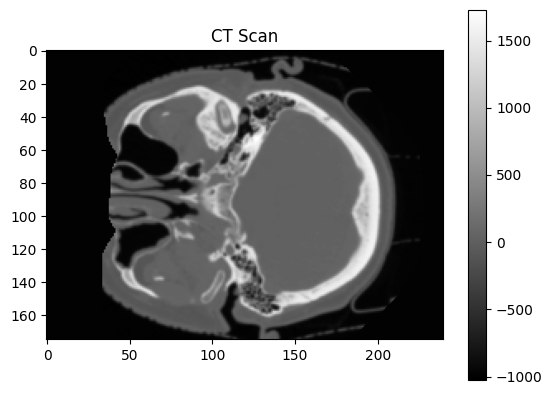

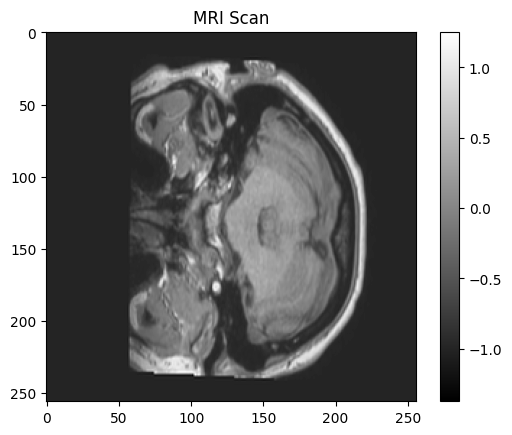

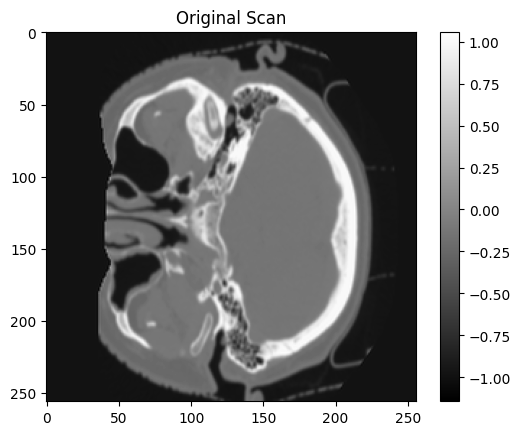

In [11]:


# NORM WITH MASK
dir_path = os.getcwd() + "/Task1/val/"
mri, ct, mask = read_data(dir_path, "1BA075")
plt.imshow(ct[:, :, 81], cmap='gray')
plt.colorbar()
plt.title("CT Scan")
plt.show()
mri = preprocess_image(mri, mask)
ct = preprocess_image(ct, mask)

mri_slice = resize_image(mri[:, :, 80:83])
ct_slice = resize_image(ct[:, :, 80:83])

plt.imshow(mri_slice[:, :, 1], cmap='gray')
plt.colorbar()
plt.title("MRI Scan")
plt.show()

plt.imshow(ct_slice[:, :, 1], cmap='gray')
plt.colorbar()
plt.title("Original Scan")
plt.show()

# plt.imshow(ct[:, :, 81], cmap='gray')
# plt.colorbar()
# plt.title("CT Scan")
# plt.show()

In [ ]:
print(inp.min(), inp.max())

In [ ]:
from PIL import Image
import numpy as np
import nibabel as nib
import nibabel.processing as nibproc
from generator_model import Generator

# Load your trained model
checkpoint = torch.load("Models/v1.5.3/gen.pth.tar")
checkpoint['state_dict'] = {k.replace('module.', ''): v for k, v in checkpoint['state_dict'].items()}

model = Generator(in_channels=3)
model.double()
model.load_state_dict(checkpoint['state_dict'])
model.eval()  # Set the model to evaluation mode

# Load an input image in the (channels, length, breadth) format
input_image_path = "Task1/val/1BA075/mr.nii.gz"
target_image_path = "Task1/val/1BA075/ct.nii.gz"

src = preprocess(input_image_path)
target = preprocess(target_image_path)

res = []

for i in [50, 60, 70, 80, 90, 100]:
    x = src[:, :, i:i+3]
    y = target[:, :, i:i+3]
    
    transform = transforms.ToTensor()
    input_tensor = transform(x).unsqueeze(0)
    
    print(x.shape)
    print(input_tensor.shape)

    with torch.no_grad():
        output_tensor = model(input_tensor)

    output_array = output_tensor.squeeze().cpu().numpy()
#     res.append(output_array.reshape(1, 256, 256))
    res.append(output_array)
    
# plt.imshow(res[3], cmap='gray')
# plt.colorbar()
# plt.title("output")
# plt.show()

# plt.imshow(target_slice, cmap='gray')
# plt.colorbar()
# plt.title("CT")
# plt.show()

In [ ]:
plt.imshow((res[5].transpose(1,2,0))[:, :, 1], cmap='gray')
plt.colorbar()
plt.title("output")
plt.show()

In [ ]:
res = np.array(res)

image_tensors = [torch.from_numpy(image) for image in res]
grid = make_grid(image_tensors, nrow=3) 

torchvision.utils.save_image(grid, 'image_grid.png')

grid_min = grid.min()
grid_max = grid.max()
grid = (grid - grid_min) / (grid_max - grid_min)
plt.imshow(grid.permute(1,2,0), cmap='gray')
plt.axis('off')
plt.show()

-0.15556860682072468


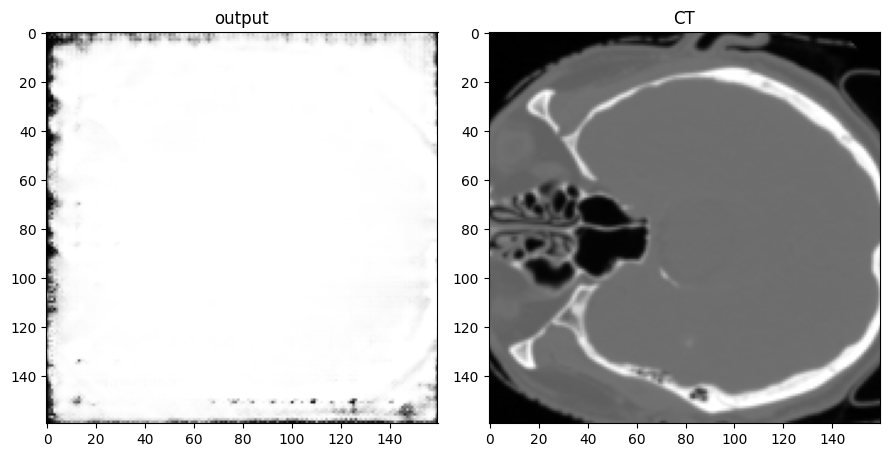

In [8]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import nibabel as nib
import nibabel.processing as nibproc
from generator_model import Generator
from resunet import resunet

# Load your trained model
checkpoint = torch.load("Models/v2.11/epochs_60/gen.pth.tar")
checkpoint['state_dict'] = {k.replace('module.', ''): v for k, v in checkpoint['state_dict'].items()}

# model = Generator(in_channels=3)
model = resunet()
model.double()
model.load_state_dict(checkpoint['state_dict'])
model.eval()  # Set the model to evaluation mode

# Load an input image in the (channels, length, breadth) format
input_image_path = "Task1/val/1BA075/mr.nii.gz"
target_image_path = "Task1/val/1BA075/ct.nii.gz"

dir_path = os.getcwd() + "/Task1/val/"
x, y, mask = read_data(dir_path, "1BA075")
x = preprocess_image(x, mask)
y = preprocess_image(y, mask)

target_slice = y[:, :, 100:103]
input_image = x[:, : , 100:103]

input_image = resize_image(input_image)
target_slice = resize_image(target_slice)

transform = transforms.ToTensor()
input_tensor = transform(input_image).unsqueeze(0)  # Add batch dimension

# Forward pass through the model
with torch.no_grad():
    output_tensor = model(input_tensor)

# Convert the output tensor to a NumPy array
output_array = output_tensor.squeeze().cpu().numpy()

# Transpose the output array back to (length, breadth, channels) format
output_array = np.transpose(output_array, (1, 2, 0))
output_array = output_array

ssim_values = []
dr = np.max(output_array) - np.min(output_array)

for channel in range(3):
    ssim_value = ssim(output_array[:, :, channel], target_slice[:, :, channel], data_range=dr)
    ssim_values.append(ssim_value)

average_ssim = np.mean(ssim_values)
print(average_ssim)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9,9))
axes[0].imshow(output_array[:, :, 0], cmap='gray')
axes[0].set_title("output")

axes[1].imshow(target_slice[:, :, 0], cmap='gray')
axes[1].set_title("CT")

plt.tight_layout()
plt.show()

In [18]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Total learnable parameters: {total_params}')

Total learnable parameters: 55420739


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import nibabel as nib
import nibabel.processing as nibproc
from generator_model import Generator

# Load your trained model
checkpoint = torch.load("Models/v1.5.3/gen.pth.tar")
checkpoint['state_dict'] = {k.replace('module.', ''): v for k, v in checkpoint['state_dict'].items()}

model = Generator(in_channels=3)
model.double()
model.load_state_dict(checkpoint['state_dict'])
model.eval()  # Set the model to evaluation mode

# Load an input image in the (channels, length, breadth) format
input_image_path = "Task1/val/1BA075/mr.nii.gz"
target_image_path = "Task1/val/1BA075/ct.nii.gz"

# nii_img = nib.load(input_image_path)
# nii_img = nibproc.resample_from_to(nii_img, [(256, 256, 160), nii_img.affine])
# input_image = np.array(nii_img.get_fdata())

# target_nii = nib.load(target_image_path)
# target_nii = nibproc.resample_from_to(target_nii, [(256, 256, 160), target_nii.affine])
# target_image = np.array(target_nii.get_fdata())
# mean = np.mean(target_image)
# std = np.std(target_image)
# target_image = (target_image - mean) / std
target_image = preprocess(target_image_path)
target_slice = target_image[:, :, 70:73]

# mean = np.mean(input_image)
# std = np.std(input_image)
# input_image = (input_image - mean) / std
input_image = preprocess(input_image_path)
input_image = input_image[:, : , 70:73]
# input_image = input_image.astype(np.float64) / 255.0
# input_image = np.transpose(input_image, (2, 0, 1))
transform = transforms.ToTensor()
input_tensor = transform(input_image).unsqueeze(0)  # Add batch dimension

# Forward pass through the model
with torch.no_grad():
    output_tensor = model(input_tensor)

# Convert the output tensor to a NumPy array
output_array = output_tensor.squeeze().cpu().numpy()

# Transpose the output array back to (length, breadth, channels) format
output_array = np.transpose(output_array, (1, 2, 0))
output_array = output_array
plt.imshow(output_array[:, :, 1], cmap='gray')
plt.colorbar()
plt.title("output")
plt.show()

plt.imshow(target_slice[:, :, 1], cmap='gray')
plt.colorbar()
plt.title("CT")
plt.show()

In [25]:
def generate_3d_volume(mri, model):
    res = np.zeros_like(mri)
    for i in range(0, mri.shape[2]-3):
        target_slice = y[:, :, i:i+3]
        input_image = x[:, : , i:i+3]

        input_image = resize_image(input_image)
        target_slice = resize_image(target_slice)

        transform = transforms.ToTensor()
        input_tensor = transform(input_image).unsqueeze(0)
        with torch.no_grad():
            output_tensor = model(input_tensor)

        pred = output_tensor.squeeze().cpu().numpy()
        pred = np.transpose(pred, (1, 2, 0))
        res[:, :, i:i+3] += pred
    res /= 3
    return res

def get_ssim(mri, ct, model):
    ssim_values = []
    psnr_values = []
    
    for i in range(0, mri.shape[2]-3):
        target_slice = ct[:, :, i:i+3]
        input_image = mri[:, : , i:i+3]

        input_image = resize_image(input_image)
        target_slice = resize_image(target_slice)

        transform = transforms.ToTensor()
        input_tensor = transform(input_image).unsqueeze(0)
        with torch.no_grad():
            output_tensor = model(input_tensor)

        pred = output_tensor.squeeze().cpu().numpy()
        pred = np.transpose(pred, (1, 2, 0))
    
        dr = np.max(pred) - np.min(pred)
        for channel in range(3):
            ssim_value = ssim(pred[:, :, channel], target_slice[:, :, channel], data_range=dr)
            psnr_value = psnr(pred[:, :, channel], target_slice[:, :, channel])
            psnr_values.append(psnr_value)
            ssim_values.append(ssim_value)

    average_ssim = np.mean(ssim_values)
    average_psnr = np.mean(psnr_values)
    return average_ssim, average_psnr

In [27]:
# Load your trained model
checkpoint = torch.load("Models/v1.5.6/gen.pth.tar")
checkpoint['state_dict'] = {k.replace('module.', ''): v for k, v in checkpoint['state_dict'].items()}

model = Generator(in_channels=3)
model.double()
model.load_state_dict(checkpoint['state_dict'])
model.eval()  # Set the model to evaluation mode

# Load an input image in the (channels, length, breadth) format
input_image_path = "Task1/val/1BA075/mr.nii.gz"
target_image_path = "Task1/val/1BA075/ct.nii.gz"

dir_path = os.getcwd() + "/Task1/val/"
x, y, mask = read_data(dir_path, "1BA075")
x = preprocess_image(x, mask)
y = preprocess_image(y, mask)

print(get_ssim(x, y, model))

# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9,9))
# axes[0].imshow(sct[:, :, 80], cmap='gray')
# axes[0].set_title("output")

# axes[1].imshow(y[:, :, 80], cmap='gray')
# axes[1].set_title("CT")

# plt.tight_layout()
# plt.show()

(0.7397945860818007, 21.960403778593346)
